In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200
        
name = 'mvi'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [2]:
import re
import torch
import numpy as np
import pickle 
import json
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

from nnsysident.training.trainers import standard_trainer
from nnsysident.models.models import stacked2d_poisson, stacked2d_zig, stacked2d_zil
from nnsysident.models.ensemble_models import Ensemble
from nnsysident.utility.data_helpers import extract_data_key
from nnsysident.datasets.mouse_loaders import static_loaders

from neuralpredictors.measures.zero_inflated_losses import ZIGLoss, ZILLoss
from neuralpredictors.measures import corr

from dataport.bcm.static import PreprocessedMouseData

random_seed = 27121992
device = 'cuda'

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Connecting konstantin@134.76.19.44:3306


---

In [3]:
# Load model architecture configurations
with open('group233_model_configs.pkl', 'rb') as handle:
    zhiwei_configs = pickle.load(handle)
    
modulator_kwargs = zhiwei_configs["mod_key"]
shifter_kwargs = zhiwei_configs["shift_key"]
modulator_kwargs["bias"] = False
shifter_kwargs["bias"] = False

In [4]:
datasets =  [{'animal_id': 26614,
              'session': 1,
              'scan_idx': 16,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26614,
              'session': 2,
              'scan_idx': 17,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 26726,
              'session': 6,
              'scan_idx': 11,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26726,
              'session': 7,
              'scan_idx': 13,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 26942,
              'session': 1,
              'scan_idx': 11,
              'scan_purpose': 'imagenet'},
             {'animal_id': 26942,
              'session': 2,
              'scan_idx': 8,
              'scan_purpose': 'dei_control_pair'},
             {'animal_id': 27468,
              'session': 3,
              'scan_idx': 12,
              'scan_purpose': 'imagenet'},
             {'animal_id': 27468,
              'session': 4,
              'scan_idx': 7,
              'scan_purpose': 'dei_control_pair'}]

## Imagenet Data

In [5]:
imagenet_key = datasets[0]
assert imagenet_key["scan_purpose"] == "imagenet"
paths = ["./data/static{}-{}-{}-GrayImageNet-7bed7f7379d99271be5d144e5e59a8e7.zip".format(imagenet_key["animal_id"], imagenet_key["session"], imagenet_key["scan_idx"])]
img_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'loader_outputs': ["images", "responses", "pupil_center", "behavior"],
                  # 'loader_outputs': ["images", "responses"],
                  'normalize': True,
                  'exclude': ["images"],
                  'subtract_behavior_mean': True
                  }
    
img_dataloaders = static_loaders(**dataset_config)
img_dataset = img_dataloaders["test"][img_data_key].dataset

---

## Models

### ZIG

In [ ]:
# for random_seed in np.arange(5):
#     loc = np.exp(-10)

#     zig_model_config = {
#         "layers": 4,
#         "hidden_channels": 64,
#         "feature_reg_weight": 0.78,
#         "init_mu_range": 0.55,
#         "init_sigma": 0.4,
#         "readout_type": "MultipleGeneralizedFullGaussian2d",
#         'grid_mean_predictor': {'type': 'cortex',
#                                   'input_dimensions': 2,
#                                   'hidden_layers': 0,
#                                   'hidden_features': 0,
#                                   'final_tanh': False},
#         'zero_thresholds': {img_data_key: loc},

#         "input_kern": 15,
#         "gamma_input": 1,
#         "hidden_kern": 13,
#         "depth_separable": True,
#         "k_image_dependent": True,
#         "modulator_kwargs": modulator_kwargs,
#         "shifter_kwargs": shifter_kwargs,
#     }


#     zig_model = stacked2d_zig(img_dataloaders, random_seed, **zig_model_config)
#     zig_model.to(device);

#     score, output, state_dict = standard_trainer(zig_model,
#                                                img_dataloaders,
#                                                random_seed, 
#                                                loss_function="ZIGLoss", 
#                                                stop_function="get_loss", 
#                                                track_training=False, 
#                                                maximize=False)
#     zig_model.eval();
#     torch.save(state_dict, "ZIG_statedict" + img_data_key + f"-seed{random_seed}" + ".inshallah")

In [6]:
loc = np.exp(-10)

zig_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "feature_reg_weight": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    "readout_type": "MultipleGeneralizedFullGaussian2d",
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},
    'zero_thresholds': {img_data_key: loc},

    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
    "k_image_dependent": True,
    "modulator_kwargs": modulator_kwargs,
    "shifter_kwargs": shifter_kwargs,
}


zig_model = stacked2d_zig(img_dataloaders, random_seed, **zig_model_config)
zig_model.to(device);

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_hash': 'a757e992ae449e3057ff1d512a51bd1e', 'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))


In [7]:
score, output, state_dict = standard_trainer(zig_model,
                                           img_dataloaders,
                                           random_seed, 
                                           loss_function="ZIGLoss", 
                                           stop_function="get_loss", 
                                           track_training=True, 
                                           maximize=False)
zig_model.eval();
# torch.save(state_dict, "ZIG_statedict" + img_data_key + ".inshallah")


# zig_model.load_state_dict(torch.load("ZIG_statedict" + img_data_key + ".inshallah"))
# zig_model.eval();

val_correlation 0.0021074924
val_loss -14306838.0
train_loss -129312440.0


Epoch 1: 100% 71/71 [00:16<00:00,  4.37it/s]


val_correlation 0.06825473
val_loss -16187410.0
train_loss -146334690.0


Epoch 2: 100% 71/71 [00:16<00:00,  4.42it/s]


val_correlation 0.09423417
val_loss -16217166.0
train_loss -146662960.0


Epoch 3: 100% 71/71 [00:15<00:00,  4.64it/s]


val_correlation 0.11753234
val_loss -16228212.0
train_loss -146776640.0


Epoch 4: 100% 71/71 [00:14<00:00,  4.94it/s]


val_correlation 0.13837206
val_loss -16253115.0
train_loss -147004260.0


Epoch 5: 100% 71/71 [00:15<00:00,  4.66it/s]


val_correlation 0.16048601
val_loss -16255338.0
train_loss -147065680.0


Epoch 6: 100% 71/71 [00:15<00:00,  4.50it/s]


val_correlation 0.17397745
val_loss -16279444.0
train_loss -147310780.0


Epoch 7: 100% 71/71 [00:14<00:00,  4.83it/s]


val_correlation 0.19384041
val_loss -16298878.0
train_loss -147585820.0


Epoch 8: 100% 71/71 [00:14<00:00,  4.92it/s]


val_correlation 0.2137255
val_loss -16327276.0
train_loss -147846270.0


Epoch 9: 100% 71/71 [00:15<00:00,  4.52it/s]


val_correlation 0.20804836
val_loss -16289674.0
train_loss -147571980.0


Epoch 10: 100% 71/71 [00:16<00:00,  4.43it/s]


val_correlation 0.23503527
val_loss -16347944.0
train_loss -148152740.0


Epoch 11: 100% 71/71 [00:15<00:00,  4.52it/s]


val_correlation 0.24534269
val_loss -16347989.0
train_loss -148317040.0


Epoch 12: 100% 71/71 [00:15<00:00,  4.71it/s]


val_correlation 0.25361246
val_loss -16353836.0
train_loss -148438300.0


Epoch 13: 100% 71/71 [00:15<00:00,  4.72it/s]


val_correlation 0.25486696
val_loss -16359348.0
train_loss -148505360.0


Epoch 14: 100% 71/71 [00:14<00:00,  4.84it/s]


val_correlation 0.25527942
val_loss -16355425.0
train_loss -148425340.0


Epoch 15: 100% 71/71 [00:16<00:00,  4.37it/s]


val_correlation 0.25930312
val_loss -16344374.0
train_loss -148484200.0


Epoch 16: 100% 71/71 [00:16<00:00,  4.32it/s]


val_correlation 0.26960525
val_loss -16380238.0
train_loss -148751490.0


Epoch 17: 100% 71/71 [00:07<00:00,  9.53it/s]


val_correlation 0.26213422
val_loss -16348044.0
train_loss -148422430.0


Epoch 18: 100% 71/71 [00:03<00:00, 21.02it/s]


val_correlation 0.26631036
val_loss -16338898.0
train_loss -148394700.0


Epoch 19: 100% 71/71 [00:03<00:00, 20.89it/s]


val_correlation 0.2705101
val_loss -16374586.0
train_loss -148804620.0


Epoch 20: 100% 71/71 [00:03<00:00, 20.87it/s]


val_correlation 0.27707797
val_loss -16387154.0
train_loss -148943680.0


Epoch 21: 100% 71/71 [00:03<00:00, 21.01it/s]


val_correlation 0.2765031
val_loss -16379559.0
train_loss -148971580.0


Epoch 22: 100% 71/71 [00:03<00:00, 20.85it/s]


val_correlation 0.27901047
val_loss -16384480.0
train_loss -148988720.0


Epoch 23: 100% 71/71 [00:03<00:00, 20.96it/s]


val_correlation 0.27903208
val_loss -16355844.0
train_loss -148854720.0


Epoch 24: 100% 71/71 [00:03<00:00, 20.87it/s]


val_correlation 0.2868574
val_loss -16395362.0
train_loss -149170640.0


Epoch 25: 100% 71/71 [00:03<00:00, 20.88it/s]


val_correlation 0.2853177
val_loss -16387014.0
train_loss -149181950.0


Epoch 26: 100% 71/71 [00:04<00:00, 15.63it/s]


val_correlation 0.28663972
val_loss -16394545.0
train_loss -149258100.0


Epoch 27: 100% 71/71 [00:06<00:00, 10.93it/s]


val_correlation 0.290886
val_loss -16406986.0
train_loss -149366060.0


Epoch 28: 100% 71/71 [00:14<00:00,  5.04it/s]


val_correlation 0.2850611
val_loss -16402894.0
train_loss -149220270.0


Epoch 29: 100% 71/71 [00:15<00:00,  4.54it/s]


val_correlation 0.29190168
val_loss -16408236.0
train_loss -149419280.0


Epoch 30: 100% 71/71 [00:16<00:00,  4.38it/s]


val_correlation 0.29124093
val_loss -16416254.0
train_loss -149418400.0


Epoch 31: 100% 71/71 [00:14<00:00,  4.79it/s]


val_correlation 0.2925948
val_loss -16414554.0
train_loss -149402380.0


Epoch 32: 100% 71/71 [00:15<00:00,  4.64it/s]


val_correlation 0.291611
val_loss -16412325.0
train_loss -149476740.0


Epoch 33: 100% 71/71 [00:15<00:00,  4.61it/s]


val_correlation 0.29337528
val_loss -16405054.0
train_loss -149550770.0


Epoch 34: 100% 71/71 [00:15<00:00,  4.56it/s]


val_correlation 0.29400972
val_loss -16413458.0
train_loss -149512850.0


Epoch 35: 100% 71/71 [00:14<00:00,  4.79it/s]


val_correlation 0.29124093
val_loss -16416254.0
train_loss -149418400.0


Epoch 36: 100% 71/71 [00:14<00:00,  4.77it/s]


Epoch 00036: reducing learning rate of group 0 to 1.5000e-03.
val_correlation 0.2860649
val_loss -16387749.0
train_loss -149370700.0


Epoch 37: 100% 71/71 [00:15<00:00,  4.50it/s]


val_correlation 0.29902712
val_loss -16416498.0
train_loss -149690320.0


Epoch 38: 100% 71/71 [00:14<00:00,  4.76it/s]


val_correlation 0.29974368
val_loss -16378600.0
train_loss -149743680.0


Epoch 39: 100% 71/71 [00:15<00:00,  4.46it/s]


val_correlation 0.30046767
val_loss -16166113.0
train_loss -149871900.0


Epoch 40: 100% 71/71 [00:16<00:00,  4.42it/s]


val_correlation 0.2969615
val_loss -15820023.0
train_loss -149639400.0


Epoch 41: 100% 71/71 [00:16<00:00,  4.31it/s]


val_correlation 0.3013432
val_loss -16284874.0
train_loss -149869330.0


Epoch 42: 100% 71/71 [00:16<00:00,  4.34it/s]


val_correlation 0.29902712
val_loss -16416498.0
train_loss -149690320.0


Epoch 43: 100% 71/71 [00:16<00:00,  4.33it/s]


Epoch 00043: reducing learning rate of group 0 to 4.5000e-04.
val_correlation 0.30081567
val_loss -16412492.0
train_loss -149807790.0


Epoch 44: 100% 71/71 [00:15<00:00,  4.64it/s]


val_correlation 0.30163237
val_loss -16409379.0
train_loss -149859440.0


Epoch 45: 100% 71/71 [00:14<00:00,  4.87it/s]


val_correlation 0.30055588
val_loss -16361762.0
train_loss -149814430.0


Epoch 46: 100% 71/71 [00:15<00:00,  4.51it/s]


val_correlation 0.30156824
val_loss -16316464.0
train_loss -149889700.0


Epoch 47: 100% 71/71 [00:15<00:00,  4.65it/s]


val_correlation: 0.29963976

zig_val_loss: -16377972.0

zig_train_loss: -150074690.0

### Poisson

In [ ]:
# for random_seed in np.arange(5):

#     poisson_model_config = {
#         "layers": 4,
#         "hidden_channels": 64,
#         "gamma_readout": 0.78,
#         "init_mu_range": 0.55,
#         "init_sigma": 0.4,
#         "readout_type": "MultipleGeneralizedFullGaussian2d",
#         'grid_mean_predictor': {'type': 'cortex',
#                                   'input_dimensions': 2,
#                                   'hidden_layers': 0,
#                                   'hidden_features': 0,
#                                   'final_tanh': False},
#         "input_kern": 15,
#         "gamma_input": 1,
#         "hidden_kern": 13,
#         "depth_separable": True,
#         "modulator_kwargs": modulator_kwargs,
#         "shifter_kwargs": shifter_kwargs,  
#     }


#     poisson_model = stacked2d_poisson(img_dataloaders, random_seed, **poisson_model_config)
#     poisson_model.to(device);

#     score, output, state_dict = standard_trainer(poisson_model,
#                                                  img_dataloaders,
#                                                  random_seed,
#                                                  loss_function="PoissonLoss",
#                                                  track_training=False, )
#     poisson_model.eval();
#     torch.save(state_dict, "Poisson_statedict" + img_data_key + f"-seed{random_seed} + ".inshallah"")

In [11]:
poisson_model_config = {
    "layers": 4,
    "hidden_channels": 64,
    "gamma_readout": 0.78,
    "init_mu_range": 0.55,
    "init_sigma": 0.4,
    "readout_type": "MultipleGeneralizedFullGaussian2d",
    'grid_mean_predictor': {'type': 'cortex',
                              'input_dimensions': 2,
                              'hidden_layers': 0,
                              'hidden_features': 0,
                              'final_tanh': False},
    "input_kern": 15,
    "gamma_input": 1,
    "hidden_kern": 13,
    "depth_separable": True,
    "modulator_kwargs": modulator_kwargs,
    "shifter_kwargs": shifter_kwargs,  
}

poisson_model = stacked2d_poisson(img_dataloaders, random_seed, **poisson_model_config)
poisson_model.to(device);

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_hash': 'a757e992ae449e3057ff1d512a51bd1e', 'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))


In [12]:
score, output, state_dict = standard_trainer(poisson_model,
                                             img_dataloaders,
                                             random_seed,
                                             loss_function="PoissonLoss",
                                             track_training=True, )
poisson_model.eval();
# torch.save(state_dict, "Poisson_statedict" + img_data_key + ".inshallah")


# poisson_model.load_state_dict(torch.load("Poisson_statedict" + img_data_key + ".inshallah"))
# poisson_model.eval();

val_correlation 0.002815332
val_loss 5145584.0
train_loss 46610176.0


Epoch 1: 100% 71/71 [00:13<00:00,  5.09it/s]


val_correlation 0.055420157
val_loss 3085190.5
train_loss 28071310.0


Epoch 2: 100% 71/71 [00:14<00:00,  4.76it/s]


val_correlation 0.09748722
val_loss 3025222.0
train_loss 27453482.0


Epoch 3: 100% 71/71 [00:14<00:00,  4.75it/s]


val_correlation 0.12878723
val_loss 2986160.8
train_loss 27135842.0


Epoch 4: 100% 71/71 [00:14<00:00,  4.85it/s]


val_correlation 0.15239626
val_loss 2951963.5
train_loss 26758528.0


Epoch 5: 100% 71/71 [00:14<00:00,  4.90it/s]


val_correlation 0.16469127
val_loss 2978438.8
train_loss 26893776.0


Epoch 6: 100% 71/71 [00:14<00:00,  4.81it/s]


val_correlation 0.18915398
val_loss 2924108.2
train_loss 26402182.0


Epoch 7: 100% 71/71 [00:15<00:00,  4.49it/s]


val_correlation 0.21335919
val_loss 2879777.5
train_loss 25924992.0


Epoch 8: 100% 71/71 [00:15<00:00,  4.53it/s]


val_correlation 0.22029214
val_loss 2884023.0
train_loss 25977758.0


Epoch 9: 100% 71/71 [00:15<00:00,  4.56it/s]


val_correlation 0.2288793
val_loss 2868416.0
train_loss 25697852.0


Epoch 10: 100% 71/71 [00:14<00:00,  4.91it/s]


val_correlation 0.25026497
val_loss 2815454.0
train_loss 25196810.0


Epoch 11: 100% 71/71 [00:14<00:00,  4.85it/s]


val_correlation 0.25581744
val_loss 2815365.8
train_loss 25072508.0


Epoch 12: 100% 71/71 [00:15<00:00,  4.56it/s]


val_correlation 0.26573005
val_loss 2800941.5
train_loss 24895298.0


Epoch 13: 100% 71/71 [00:15<00:00,  4.70it/s]


val_correlation 0.26439744
val_loss 2813885.2
train_loss 24989086.0


Epoch 14: 100% 71/71 [00:14<00:00,  4.85it/s]


val_correlation 0.27315736
val_loss 2778892.8
train_loss 24659888.0


Epoch 15: 100% 71/71 [00:14<00:00,  4.86it/s]


val_correlation 0.2719815
val_loss 2809459.2
train_loss 24850296.0


Epoch 16: 100% 71/71 [00:15<00:00,  4.45it/s]


val_correlation 0.28650442
val_loss 2760272.5
train_loss 24406926.0


Epoch 17: 100% 71/71 [00:14<00:00,  4.96it/s]


val_correlation 0.28079066
val_loss 2792455.5
train_loss 24764658.0


Epoch 18: 100% 71/71 [00:07<00:00,  9.82it/s]


val_correlation 0.28287077
val_loss 2786150.8
train_loss 24647302.0


Epoch 19: 100% 71/71 [00:03<00:00, 23.27it/s]


val_correlation 0.29127795
val_loss 2770097.5
train_loss 24371656.0


Epoch 20: 100% 71/71 [00:03<00:00, 23.35it/s]


val_correlation 0.29798567
val_loss 2741800.5
train_loss 24059562.0


Epoch 21: 100% 71/71 [00:03<00:00, 22.55it/s]


val_correlation 0.3015742
val_loss 2744832.8
train_loss 24086000.0


Epoch 22: 100% 71/71 [00:03<00:00, 22.92it/s]


val_correlation 0.30260792
val_loss 2739916.0
train_loss 24004322.0


Epoch 23: 100% 71/71 [00:03<00:00, 22.68it/s]


val_correlation 0.30668113
val_loss 2723652.0
train_loss 23843112.0


Epoch 24: 100% 71/71 [00:03<00:00, 23.18it/s]


val_correlation 0.30798036
val_loss 2732102.5
train_loss 23849442.0


Epoch 25: 100% 71/71 [00:03<00:00, 23.17it/s]


val_correlation 0.30825162
val_loss 2730158.5
train_loss 23784354.0


Epoch 26: 100% 71/71 [00:03<00:00, 23.00it/s]


val_correlation 0.30953124
val_loss 2720454.0
train_loss 23734840.0


Epoch 27: 100% 71/71 [00:03<00:00, 22.92it/s]


val_correlation 0.31123593
val_loss 2719177.0
train_loss 23671552.0


Epoch 28: 100% 71/71 [00:03<00:00, 23.04it/s]


val_correlation 0.31087062
val_loss 2720831.5
train_loss 23810494.0


Epoch 29: 100% 71/71 [00:03<00:00, 23.01it/s]


val_correlation 0.31251773
val_loss 2723537.5
train_loss 23681146.0


Epoch 30: 100% 71/71 [00:03<00:00, 23.07it/s]


val_correlation 0.31647083
val_loss 2706219.5
train_loss 23593854.0


Epoch 31: 100% 71/71 [00:03<00:00, 21.47it/s]


val_correlation 0.31444034
val_loss 2713339.5
train_loss 23592370.0


Epoch 32: 100% 71/71 [00:05<00:00, 11.90it/s]


val_correlation 0.31291294
val_loss 2720489.0
train_loss 23638326.0


Epoch 33: 100% 71/71 [00:08<00:00,  8.39it/s]


val_correlation 0.3160452
val_loss 2723494.0
train_loss 23573918.0


Epoch 34: 100% 71/71 [00:14<00:00,  4.99it/s]


val_correlation 0.31885833
val_loss 2704347.2
train_loss 23527516.0


Epoch 35: 100% 71/71 [00:14<00:00,  4.75it/s]


val_correlation 0.3170678
val_loss 2712369.0
train_loss 23467986.0


Epoch 36: 100% 71/71 [00:15<00:00,  4.48it/s]


val_correlation 0.31803873
val_loss 2710552.5
train_loss 23416294.0


Epoch 37: 100% 71/71 [00:14<00:00,  4.78it/s]


val_correlation 0.31344876
val_loss 2734662.8
train_loss 23607358.0


Epoch 38: 100% 71/71 [00:15<00:00,  4.73it/s]


val_correlation 0.3216718
val_loss 2701085.0
train_loss 23406940.0


Epoch 39: 100% 71/71 [00:14<00:00,  4.76it/s]


val_correlation 0.31760737
val_loss 2719365.5
train_loss 23516110.0


Epoch 40: 100% 71/71 [00:15<00:00,  4.65it/s]


val_correlation 0.31981212
val_loss 2709153.5
train_loss 23383660.0


Epoch 41: 100% 71/71 [00:15<00:00,  4.47it/s]


val_correlation 0.3227419
val_loss 2699070.5
train_loss 23315474.0


Epoch 42: 100% 71/71 [00:15<00:00,  4.52it/s]


val_correlation 0.31823367
val_loss 2718453.0
train_loss 23513982.0


Epoch 43: 100% 71/71 [00:15<00:00,  4.59it/s]


val_correlation 0.32534817
val_loss 2698584.2
train_loss 23201986.0


Epoch 44: 100% 71/71 [00:14<00:00,  4.79it/s]


val_correlation 0.32144895
val_loss 2707228.5
train_loss 23224992.0


Epoch 45: 100% 71/71 [00:15<00:00,  4.72it/s]


val_correlation 0.31686077
val_loss 2716389.8
train_loss 23364940.0


Epoch 46: 100% 71/71 [00:15<00:00,  4.63it/s]


val_correlation 0.32363176
val_loss 2705696.8
train_loss 23334928.0


Epoch 47: 100% 71/71 [00:15<00:00,  4.54it/s]


val_correlation 0.32640284
val_loss 2694533.0
train_loss 23167336.0


Epoch 48: 100% 71/71 [00:15<00:00,  4.56it/s]


val_correlation 0.32544345
val_loss 2688381.8
train_loss 23170718.0


Epoch 49: 100% 71/71 [00:15<00:00,  4.71it/s]


val_correlation 0.3191604
val_loss 2713831.2
train_loss 23226176.0


Epoch 50: 100% 71/71 [00:13<00:00,  5.14it/s]


val_correlation 0.32308677
val_loss 2706211.5
train_loss 23236626.0


Epoch 51: 100% 71/71 [00:14<00:00,  4.88it/s]


val_correlation 0.323854
val_loss 2701469.0
train_loss 23109254.0


Epoch 52: 100% 71/71 [00:14<00:00,  5.00it/s]


val_correlation 0.32640284
val_loss 2694533.0
train_loss 23167338.0


Epoch 53: 100% 71/71 [00:13<00:00,  5.12it/s]


Epoch 00053: reducing learning rate of group 0 to 1.5000e-03.
val_correlation 0.32363233
val_loss 2697202.0
train_loss 23192312.0


Epoch 54: 100% 71/71 [00:14<00:00,  4.99it/s]


val_correlation 0.33206448
val_loss 2678360.0
train_loss 22883124.0


Epoch 55: 100% 71/71 [00:08<00:00,  7.95it/s]


val_correlation 0.32985273
val_loss 2689299.0
train_loss 22895168.0


Epoch 56: 100% 71/71 [00:04<00:00, 16.11it/s]


val_correlation 0.32132903
val_loss 2709951.0
train_loss 23150152.0


Epoch 57: 100% 71/71 [00:03<00:00, 22.98it/s]


val_correlation 0.32089055
val_loss 2714652.8
train_loss 23190446.0


Epoch 58: 100% 71/71 [00:03<00:00, 22.55it/s]


val_correlation 0.32973176
val_loss 2689771.0
train_loss 22841614.0


Epoch 59: 100% 71/71 [00:03<00:00, 23.11it/s]


val_correlation 0.33206448
val_loss 2678360.0
train_loss 22883122.0


Epoch 60: 100% 71/71 [00:03<00:00, 22.94it/s]


Epoch 00060: reducing learning rate of group 0 to 4.5000e-04.
val_correlation 0.3224
val_loss 2710096.0
train_loss 23111920.0


Epoch 61: 100% 71/71 [00:03<00:00, 22.76it/s]


val_correlation 0.33356348
val_loss 2675277.0
train_loss 22846674.0


Epoch 62: 100% 71/71 [00:03<00:00, 22.96it/s]


val_correlation 0.33016422
val_loss 2685981.2
train_loss 22842034.0


Epoch 63: 100% 71/71 [00:03<00:00, 23.06it/s]


val_correlation 0.3301397
val_loss 2688239.0
train_loss 22825020.0


Epoch 64: 100% 71/71 [00:03<00:00, 23.23it/s]


val_correlation 0.3301097
val_loss 2691213.2
train_loss 22807540.0


Epoch 65: 100% 71/71 [00:04<00:00, 15.41it/s]


val_correlation 0.32767773
val_loss 2693009.0
train_loss 22898712.0


Epoch 66: 100% 71/71 [00:05<00:00, 12.37it/s]


In [22]:
score

0.32780504

val_correlation 0.32643822

val_loss 2107371.0

train_loss 17724226.0

---

# Compare DEIs/MEIs

### DEI data

In [15]:
idx = np.array([(dat["animal_id"] == imagenet_key["animal_id"]) & (dat["session"] != imagenet_key["session"]) & (dat["scan_idx"] != imagenet_key["scan_idx"]) for dat in datasets])
dei_key = np.array(datasets)[idx].item()

assert dei_key["scan_purpose"] == "dei_control_pair"
paths = ["./data/static{}-{}-{}-GrayImageNetDEIInfo-7bed7f7379d99271be5d144e5e59a8e7.zip".format(dei_key["animal_id"], dei_key["session"], dei_key["scan_idx"])]
dei_data_key = extract_data_key(paths[0])

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': random_seed,
                  'return_test_sampler': True,
                  'tier': "test",
                  'loader_outputs': ["images", 'responses', 'trial_idx', "dei_unit_ids", "dei_src_unit_ids", "dei_mean_distances"],
                  'normalize': True,
                  'exclude': ["images", "trial_idx", "dei_unit_ids", "dei_src_unit_ids", "dei_mean_distances"],
                  'subtract_behavior_mean': True}

dei_dataloaders = static_loaders(**dataset_config)

dei_dataset = dei_dataloaders["test"][dei_data_key].dataset

Returning only test sampler with repeats...


In [16]:
images, responses, trial_idxs, dei_unit_ids, dei_src_unit_ids, dei_mean_distances = [], [], [], [], [], []
for image, response, trial_idx, dei_unit_id, dei_src_unit_id, dei_mean_distance in dei_dataloaders["test"][dei_data_key]:
    if (len(response) == 20) & (torch.unique(dei_mean_distance <= 10)):
        images.append(image)
        responses.append(response)
        trial_idxs.append(trial_idx)
        dei_unit_ids.append(dei_unit_id)
        dei_src_unit_ids.append(dei_src_unit_id)
        dei_mean_distances.append(dei_mean_distance)
images = torch.stack(images)
responses = torch.stack(responses)
trial_idxs = torch.stack(trial_idxs).cpu().data.numpy()
dei_unit_ids = torch.stack(dei_unit_ids).cpu().data.numpy()
dei_src_unit_ids = torch.stack(dei_src_unit_ids).cpu().data.numpy()
dei_mean_distances = torch.stack(dei_mean_distances).cpu().data.numpy()

In [17]:
# Get possible unit ids (in the source-dataset frame)
possible_src_unit_ids = np.unique(dei_src_unit_ids, axis=1).squeeze()

# Sort according to mean distances (increasing)
src_sort_idx = np.argsort(np.unique(dei_mean_distances, axis=1).squeeze())
possible_src_unit_ids = possible_src_unit_ids[src_sort_idx]

# Remove duplicates (from several DEIs/MEI)
_, idx = np.unique(possible_src_unit_ids, return_index=True)
possible_src_unit_ids = possible_src_unit_ids[np.sort(idx)]

zig_model = Ensemble(zig_se2d_fullgaussian2d, zig_model_config, img_dataloaders, "ZIG_statedict" + img_data_key, np.arange(5), device=device)
poisson_model = Ensemble(poisson_se2d_fullgaussian2d, poisson_model_config, img_dataloaders, "Poisson_statedict" + img_data_key, np.arange(5), device=device)

# zig_model.shifter = None
# poisson_model.shifter = None
# poisson_model.modulator = None

In [18]:
zig_means = np.full((3, len(possible_src_unit_ids)), np.nan)
zig_variances = np.full((3, len(possible_src_unit_ids)), np.nan)
poisson_means = np.full((3, len(possible_src_unit_ids)), np.nan)
poisson_variances = np.full((3, len(possible_src_unit_ids)), np.nan)
real_resp_means = np.full((3, len(possible_src_unit_ids)), np.nan)
real_resp_vars = np.full((3, len(possible_src_unit_ids)), np.nan)
imgs = np.full((3, len(possible_src_unit_ids), 1, 36, 64), np.nan)
for i, possible_src_unit_id in enumerate(possible_src_unit_ids):
    image_idx = np.unique(np.where(dei_src_unit_ids == possible_src_unit_id)[0])

    dei_neuron_id = np.unique(dei_unit_ids[image_idx]).item()
    src_neuron_id = np.unique(dei_src_unit_ids[image_idx]).item()
    src_neuron_idx = np.where(img_dataset.neurons.unit_ids == src_neuron_id)[0].item()
    dei_neuron_idx = np.where(dei_dataset.neurons.unit_ids == dei_neuron_id)[0].item()

    img = torch.unique(images[image_idx], dim=1).squeeze(1)
    mei_dei_idx = [0, 1, 2]
    if len(image_idx) != 3:
        idx = np.where(np.isin(dei_dataset.trial_info.trial_idx, trial_idxs[image_idx]))[0]
        if 'mask_fixed_mei' in np.unique(dei_dataset.trial_info.frame_image_class[idx]):
            mei_dei_idx = [0, 1] if len(image_idx) == 2 else [0]
        else:
            mei_dei_idx = [1, 2] if len(image_idx) == 2 else [1]
    imgs[mei_dei_idx, i, :, :, :] = img.cpu().data
    
    # TODO: Keep this line?
#     img = torch.stack([((im - im.mean()) / (im.std())) for im in img.squeeze()])[:, None]

    behavior = torch.zeros((img.shape[0], 3)).to(device)
    pupil_center = torch.zeros((img.shape[0], 2)).to(device)
    
    zig_means_ = zig_model.predict_mean(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    zig_variances_ = zig_model.predict_variance(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    poisson_means_ = poisson_model.predict_mean(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    poisson_variances_ = poisson_model.predict_variance(img, data_key=img_data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()

    zig_means[mei_dei_idx, i] = zig_means_[:, src_neuron_idx]
    zig_variances[mei_dei_idx, i] = zig_variances_[:, src_neuron_idx]
    poisson_means[mei_dei_idx, i] = poisson_means_[:, src_neuron_idx]
    poisson_variances[mei_dei_idx, i] = poisson_variances_[:, src_neuron_idx]
    
    real_resp_means[mei_dei_idx, i] = np.mean(responses[image_idx].cpu().data.numpy(), axis=1)[:, dei_neuron_idx]
    real_resp_vars[mei_dei_idx, i] = np.var(responses[image_idx].cpu().data.numpy(), axis=1)[:, dei_neuron_idx]
keep_idx = ~np.isnan(zig_means).any(axis=0)

### Compare Zhiwei Model with Konstantin model

In [19]:
with open(r"group233_mei_dei_resps.pkl", "rb") as input_file:
    e = pickle.load(input_file).T

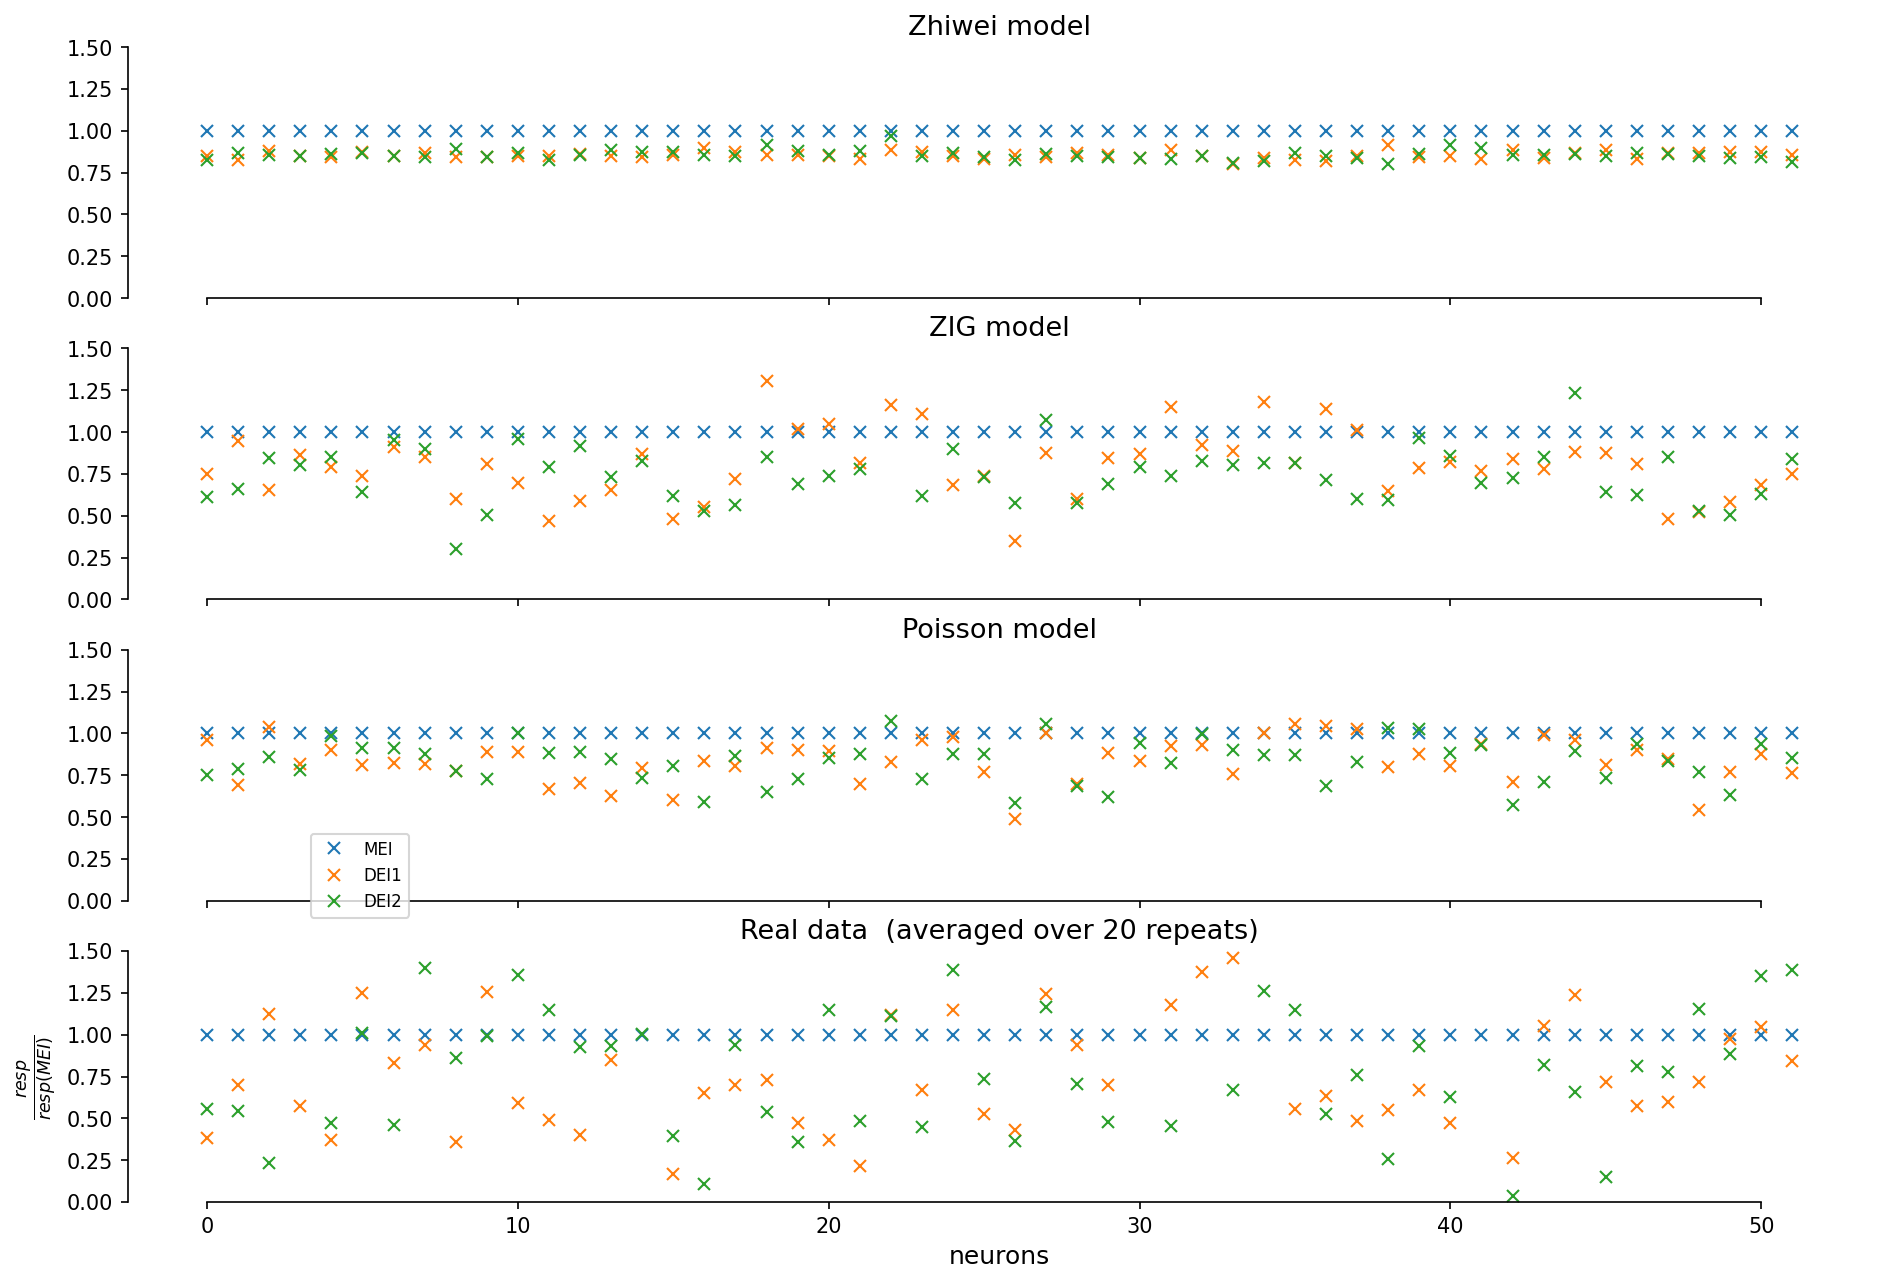

In [26]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10), dpi=150, sharex=True, sharey=True)
fontsize = 10


y_zhiwei = e / e[0, :]
y_zig = zig_means / zig_means[0, :]
y_zig = y_zig[:, keep_idx]
y_poisson = poisson_means / poisson_means[0, :]
y_poisson = y_poisson[:, keep_idx]
y_real = real_resp_means / real_resp_means[0, :]
y_real = y_real[:, keep_idx]
x = np.arange(y_real.shape[1])

# Zhiwei
for i in range(3):
    axes[0].plot(x, y_zhiwei[i,:], ls="", marker="x")

# ZIG
for i in range(3):
    axes[1].plot(x, y_zig[i,:], ls="", marker="x")
    
# Poisson
for i in range(3):
    axes[2].plot(x, y_poisson[i,:], ls="", marker="x")
    axes[2].ticklabel_format(useOffset=False)
    
# Real data
for i, label in enumerate(["MEI", "DEI1", "DEI2"]):
    axes[3].plot(x, y_real[i,:], ls="", marker="x", label=label)
    
    
axes[0].set_title("Zhiwei model", fontsize=fontsize*1.3)
axes[1].set_title("ZIG model", fontsize=fontsize*1.3)
axes[2].set_title("Poisson model", fontsize=fontsize*1.3)
axes[3].set_title("Real data  (averaged over 20 repeats)", fontsize=fontsize*1.3)
axes[3].set_xlabel("neurons", fontsize=fontsize*1.2)
axes[3].set_ylabel(r"$\frac{resp}{resp(MEI)}$", fontsize=fontsize*1.2)

axes[0].set(ylim=[0, 1.5])

# axes[3].legend(bbox_to_anchor=(0.15, 1., 0, 0), frameon=True, fontsize=fontsize*.8)
axes[3].legend(bbox_to_anchor=(0.1, 1.1, 0, 0), frameon=True, fontsize=fontsize*.8)

sns.despine(trim=True)
# fig.savefig("Zhiwei_Model_Comparison" + ".png", bbox_inches="tight", transparent=False)

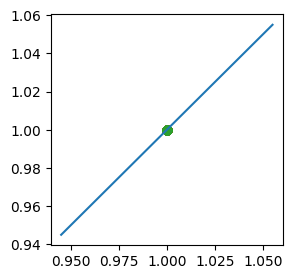

In [21]:
fig, ax = plt.subplots()
ax.scatter(y_zhiwei[0], y_poisson[0])
ax.scatter(y_zhiwei[0], y_zig[0])
ax.scatter(y_zhiwei[0], y_real[0])
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]])

#### Rank correlation

In [22]:
zig_zhiwei, poisson_zhiwei, zig_real, poisson_real, zhiwei_real = [], [], [], [], []
for i in range(e.shape[-1]):
    zig_zhiwei_, p = spearmanr(e[:, i], zig_means[:, keep_idx][:, i], axis=0)
    poisson_zhiwei_, p = spearmanr(e[:, i], poisson_means[:, keep_idx][:, i], axis=0)
    zig_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], zig_means[:, keep_idx][:, i], axis=0)
    poisson_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], poisson_means[:, keep_idx][:, i], axis=0)
    zhiwei_real_, p = spearmanr(real_resp_means[:, keep_idx][:, i], e[:, i], axis=0)
    
    zig_zhiwei.append(zig_zhiwei_)
    poisson_zhiwei.append(poisson_zhiwei_)
    zig_real.append(zig_real_)
    poisson_real.append(poisson_real_)
    zhiwei_real.append(zhiwei_real_)

print("ZIG     |  Zhiwei: {:.5f}".format(np.mean(zig_zhiwei)))
print("Poisson |  Zhiwei: {:.5f}".format(np.mean(poisson_zhiwei)))
print("ZIG     |  Real:   {:.5f}".format(np.mean(zig_real)))
print("Poisson |  Real:   {:.5f}".format(np.mean(poisson_real)))
print("Zhiwei  |  Real:   {:.5f}".format(np.mean(zhiwei_real)))

ZIG     |  Zhiwei: 0.59615
Poisson |  Zhiwei: 0.65385
ZIG     |  Real:   0.34615
Poisson |  Real:   0.38462
Zhiwei  |  Real:   0.29808


#### Full Correlation

In [23]:
zig_zhiwei = np.mean(corr(e, zig_means[:, keep_idx], axis=0))
poisson_zhiwei = np.mean(corr(e, poisson_means[:, keep_idx], axis=0))
zig_real = np.mean(corr(real_resp_means[:, keep_idx], zig_means[:, keep_idx], axis=0))
poisson_real = np.mean(corr(real_resp_means[:, keep_idx], poisson_means[:, keep_idx], axis=0))
zhiwei_real = np.mean(corr(real_resp_means[:, keep_idx], e, axis=0))

print("ZIG     |  Zhiwei: {:.5f}".format(np.mean(zig_zhiwei)))
print("Poisson |  Zhiwei: {:.5f}".format(np.mean(poisson_zhiwei)))
print("ZIG     |  Real:   {:.5f}".format(np.mean(zig_real)))
print("Poisson |  Real:   {:.5f}".format(np.mean(poisson_real)))
print("Zhiwei  |  Real:   {:.5f}".format(np.mean(zhiwei_real)))

ZIG     |  Zhiwei: 0.71968
Poisson |  Zhiwei: 0.73306
ZIG     |  Real:   0.35831
Poisson |  Real:   0.43387
Zhiwei  |  Real:   0.34435


___

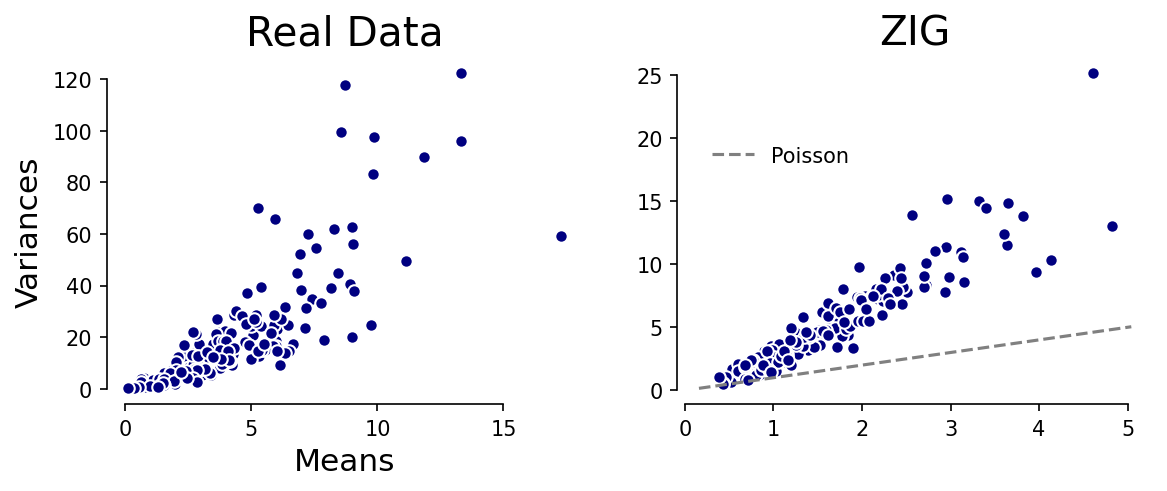

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
color = "navy"
ec="white"
fontsize = 15

axes[0].scatter(real_resp_means.flatten(), real_resp_vars.flatten(), color=color, ec=ec)
axes[0].set_xlabel("Means", fontsize=fontsize)
axes[0].set_ylabel("Variances", fontsize=fontsize)
axes[0].set_title("Real Data", fontsize=fontsize*1.3)

axes[1].scatter(zig_means.flatten(), zig_variances.flatten(), color=color, ec=ec)
axes[1].set_title("ZIG", fontsize=fontsize*1.3)
axes[1].plot([axes[1].get_xlim()[0], axes[1].get_xlim()[1]], [axes[1].get_xlim()[0], axes[1].get_xlim()[1]], ls="--", color="grey", label="Poisson")
# axes[1].set(xlim=[0, 15], ylim=[0, 400])
axes[1].legend(frameon=False, bbox_to_anchor=[.4,.8,0,0])
sns.despine(trim=True)

# fig.savefig("mean_variance_comparison" + ".png", bbox_inches="tight", transparent=False)

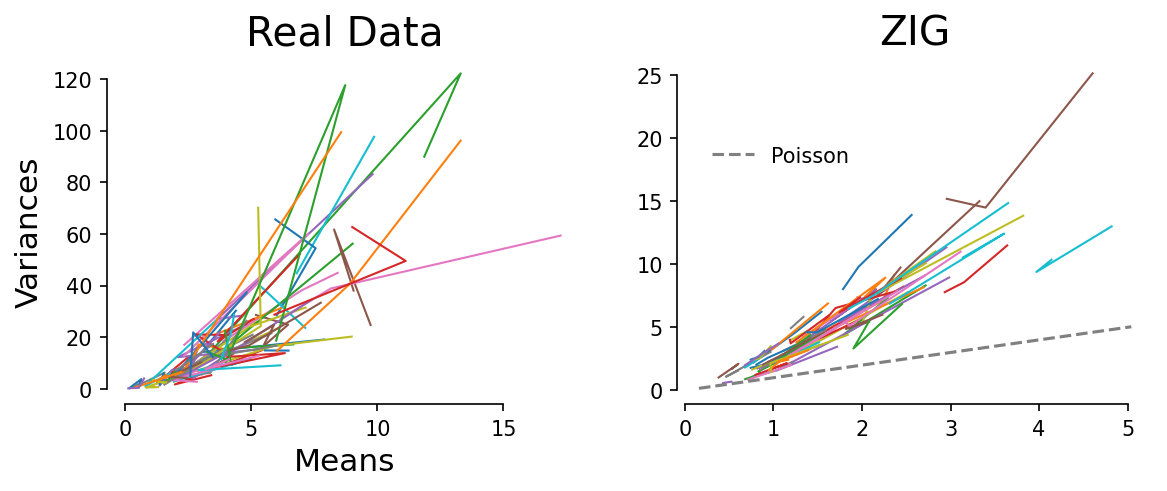

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
color = "navy"
ec="white"
fontsize = 15

axes[0].plot(real_resp_means, real_resp_vars, marker="", lw=1)
axes[0].set_xlabel("Means", fontsize=fontsize)
axes[0].set_ylabel("Variances", fontsize=fontsize)
axes[0].set_title("Real Data", fontsize=fontsize*1.3)

axes[1].plot(zig_means, zig_variances, marker="", lw=1)
axes[1].set_title("ZIG", fontsize=fontsize*1.3)
axes[1].plot([axes[1].get_xlim()[0], axes[1].get_xlim()[1]], [axes[1].get_xlim()[0], axes[1].get_xlim()[1]], ls="--", color="grey", label="Poisson")
# axes[1].set(xlim=[0, 15], ylim=[0, 400])
axes[1].legend(frameon=False, bbox_to_anchor=[.4,.8,0,0])
sns.despine(trim=True)

# fig.savefig("mean_variance_comparison_lines" + ".png", bbox_inches="tight", transparent=False)